In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
# JULY 13 JULY 14 REMOVED - IB MISTAKE


# Fetch 10-year Treasury yield using yfinance
def get_risk_free_rate_yfinance():
    treasury_data = yf.download('^TNX', period='1d')
    # Convert the yield from percentage to decimal
    return treasury_data['Close'].iloc[-1] / 100

# Load data from Excel sheets
def load_data(file_path):
    df_greg = pd.read_excel(file_path, sheet_name='Greg')
    df_chris = pd.read_excel(file_path, sheet_name='Chris')
    
    # Convert the 'Date' column to datetime if not already
    df_greg['Date'] = pd.to_datetime(df_greg['Date'])
    df_chris['Date'] = pd.to_datetime(df_chris['Date'])
    
    # Set 'Date' as the index
    df_greg.set_index('Date', inplace=True)
    df_chris.set_index('Date', inplace=True)

    # Remove July 13 and July 14 - IB MISTAKE
    df_greg = df_greg[~df_greg.index.isin(pd.to_datetime(['2023-07-13', '2023-07-14']))]
    df_chris = df_chris[~df_chris.index.isin(pd.to_datetime(['2023-07-13', '2023-07-14']))]
    
    return df_greg, df_chris

# Function to calculate performance metrics
def calculate_performance_metrics(df_greg, df_chris, risk_free_rate):
    trading_days = 252
    
    # Combine returns
    df_combined = pd.concat([df_greg['Returns'], df_chris['Returns']], axis=1)
    df_combined.columns = ['Returns_greg', 'Returns_chris']
    
    # Convert returns from percentage to decimal for calculations
    df_combined /= 100
    
    # Calculate annualized returns and volatility
    annualized_return = df_combined.mean() * trading_days
    annualized_volatility = df_combined.std() * np.sqrt(trading_days)
    
    # Calculate Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # Calculate Sortino Ratio
    downside_volatility = df_combined[df_combined < 0].std() * np.sqrt(trading_days)
    sortino_ratio = (annualized_return - risk_free_rate) / downside_volatility
    
    # Maximum Drawdown function
    def max_drawdown(returns):
        cumulative_returns = (1 + returns).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        return drawdown.min()
    
    max_drawdown_greg = max_drawdown(df_combined['Returns_greg'])
    max_drawdown_chris = max_drawdown(df_combined['Returns_chris'])
    
    return (annualized_return, annualized_volatility, sharpe_ratio,
            sortino_ratio, max_drawdown_greg, max_drawdown_chris)

# Function to optimize portfolio for maximum Sharpe ratio
def optimize_portfolio(df_greg, df_chris, risk_free_rate):
    
    # Combine returns
    df_combined = pd.concat([df_greg['Returns'], df_chris['Returns']], axis=1)
    df_combined.columns = ['Returns_greg', 'Returns_chris']
    
    # Convert returns from percentage to decimal for calculations
    df_combined /= 100
    
    # Portfolio metrics function
    def portfolio_metrics(weights, returns):
        trading_days = 252
        portfolio_return = np.sum(returns.mean() * weights) * trading_days
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * trading_days, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        return portfolio_return, portfolio_volatility, sharpe_ratio
    
    # Initial guess for weights
    initial_weights = np.array([0.5, 0.5])
    
    # Constraints (weights must sum to 1)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Bounds (weights between 0 and 1)
    bounds = ((0, 1), (0, 1))
    
    # Objective function (negative Sharpe ratio for minimization)
    def negative_sharpe(weights):
        return -portfolio_metrics(weights, df_combined)[2]
    
    # Minimize the negative Sharpe ratio
    result = minimize(negative_sharpe, initial_weights, method='SLSQP',
                      bounds=bounds, constraints=constraints)
    
    optimal_weights = result.x
    optimal_return, optimal_volatility, optimal_sharpe_ratio = portfolio_metrics(optimal_weights, df_combined)
    
    return optimal_weights, optimal_return, optimal_volatility, optimal_sharpe_ratio

# Example usage:
file_path = r"C:\Users\MukeshwaranBaskaran\Downloads\Project_KISKI\Data\chris greg daily returns.xlsx"

risk_free_rate_input = get_risk_free_rate_yfinance()
print(f"Current Risk-Free Rate (10-Year Treasury): {risk_free_rate_input:.4f}")

df_greg, df_chris = load_data(file_path)

# Calculate performance metrics
metrics = calculate_performance_metrics(df_greg, df_chris, risk_free_rate_input)
print("\nPerformance Metrics:")
print(f"Annualized Return: Greg: {metrics[0]['Returns_greg']:.2f}, Chris: {metrics[0]['Returns_chris']:.2f}")
print(f"Sharpe Ratio: Greg: {metrics[2]['Returns_greg']:.2f}, Chris: {metrics[2]['Returns_chris']:.2f}")
print(f"Sortino Ratio: Greg: {metrics[3]['Returns_greg']:.2f}, Chris: {metrics[3]['Returns_chris']:.2f}")
print(f"Max Drawdown: Greg: {metrics[4]:.2%}, Chris: {metrics[5]:.2%}")

# # Optimize portfolio
# optimal_weights, optimal_return, optimal_volatility, optimal_sharpe_ratio = optimize_portfolio(df_greg, df_chris, risk_free_rate_input)

# print("\nOptimized Portfolio:")
# print(f"Optimal Weights: Greg: {optimal_weights[0]:.2f}, Chris: {optimal_weights[1]:.2f}")
# print(f"Expected Annual Return: {optimal_return:.2f}")
# print(f"Expected Volatility: {optimal_volatility:.2f}")
# print(f"Optimal Sharpe Ratio: {optimal_sharpe_ratio:.2f}")

#Greg sharpe 1.
# Chris 10% drawdown 

[*********************100%***********************]  1 of 1 completed

Current Risk-Free Rate (10-Year Treasury): 0.0410

Performance Metrics:
Annualized Return: Greg: 0.17, Chris: 0.18
Sharpe Ratio: Greg: 1.10, Chris: 1.57
Sortino Ratio: Greg: 1.37, Chris: 2.23
Max Drawdown: Greg: -8.97%, Chris: -5.69%


In [11]:
# Function to calculate correlation
def calculate_correlation(df_greg, df_chris):
    df_combined = pd.concat([df_greg['Returns'], df_chris['Returns']], axis=1)
    df_combined.columns = ['Returns_greg', 'Returns_chris']
    df_combined.dropna(inplace=True)  # Ensure no NaN values for correlation calculation
    correlation = df_combined.corr().iloc[0, 1]  # Get correlation coefficient between the two
    return correlation

# Calculate correlation
correlation = calculate_correlation(df_greg, df_chris)
print(f"\nCorrelation between Greg and Chris returns: {correlation:.4f}")


Correlation between Greg and Chris returns: 0.6464


[*********************100%***********************]  1 of 1 completed


Current Risk-Free Rate (10-Year Treasury): 0.0410



[*********************100%***********************]  2 of 2 completed
C:\Users\MukeshwaranBaskaran\AppData\Local\Temp\ipykernel_5696\3269486528.py:37: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data['Adj Close'].pct_change().dropna()



Greg's Correlation Matrix:
          Returns       SPY       XBI    Mkt-RF       SMB       HML       RMW  \
Returns  1.000000  0.258760  0.599606  0.290861  0.424200  0.040662 -0.454096   
SPY      0.258760  1.000000  0.505130  0.994037  0.175308 -0.159320 -0.270361   
XBI      0.599606  0.505130  1.000000  0.546947  0.612661 -0.068548 -0.667882   
Mkt-RF   0.290861  0.994037  0.546947  1.000000  0.255727 -0.133505 -0.321867   
SMB      0.424200  0.175308  0.612661  0.255727  1.000000  0.404506 -0.464918   
HML      0.040662 -0.159320 -0.068548 -0.133505  0.404506  1.000000  0.162690   
RMW     -0.454096 -0.270361 -0.667882 -0.321867 -0.464918  0.162690  1.000000   
CMA      0.071169 -0.332287 -0.078119 -0.333200  0.129277  0.492552  0.138325   
RF       0.014617 -0.010670  0.019346 -0.011830  0.009005  0.153491  0.001602   

              CMA        RF  
Returns  0.071169  0.014617  
SPY     -0.332287 -0.010670  
XBI     -0.078119  0.019346  
Mkt-RF  -0.333200 -0.011830  
SMB      0.

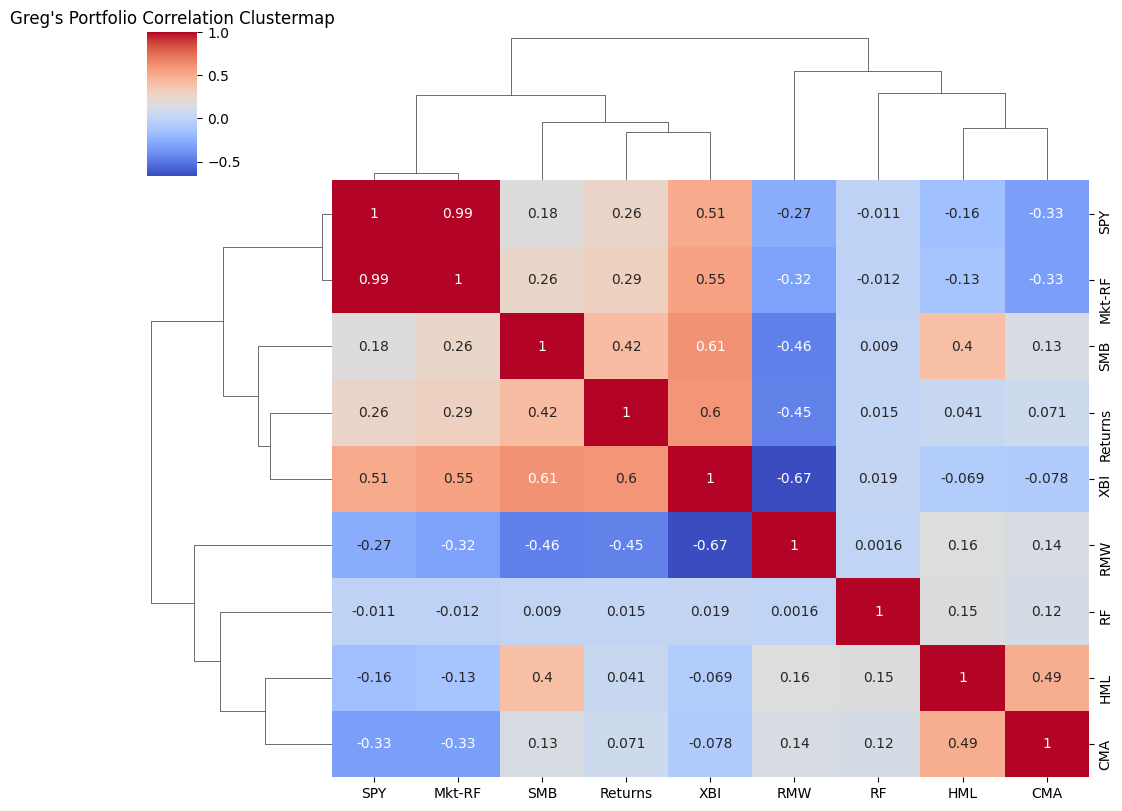

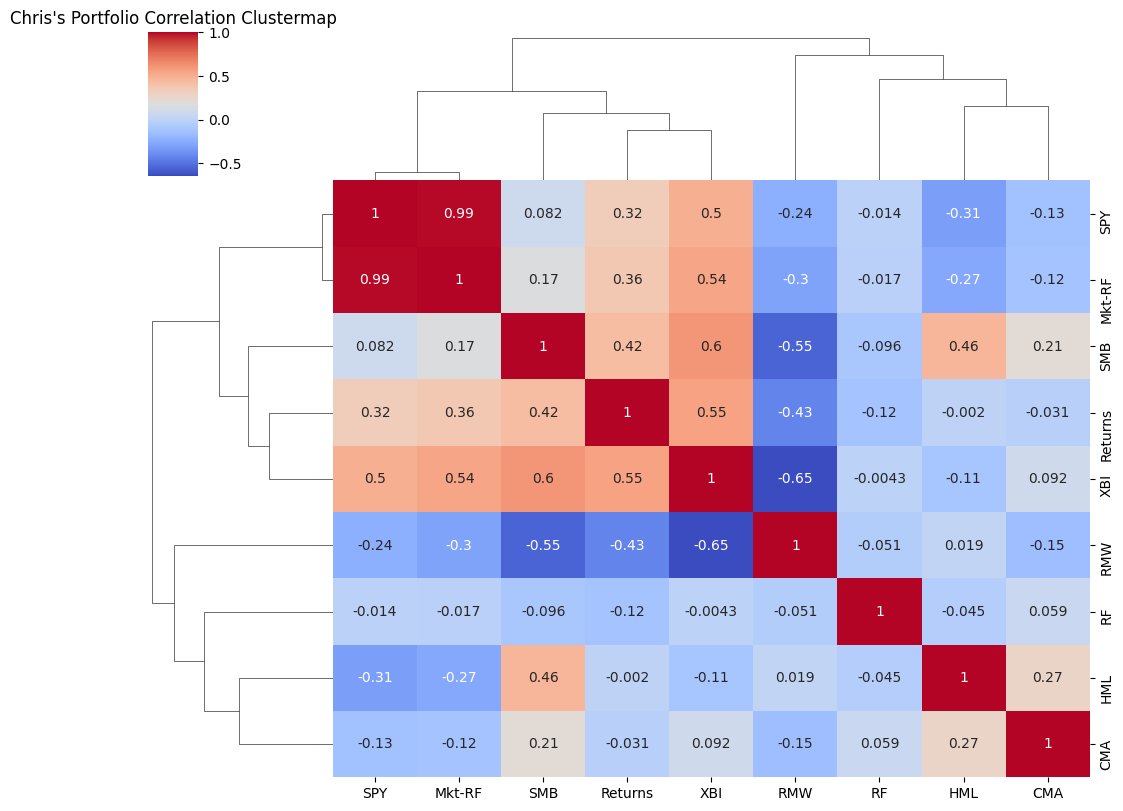

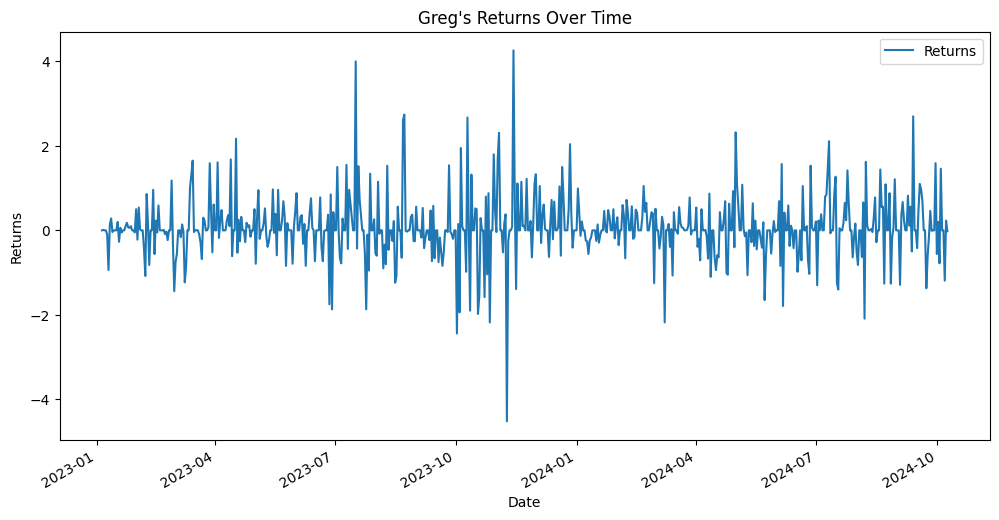

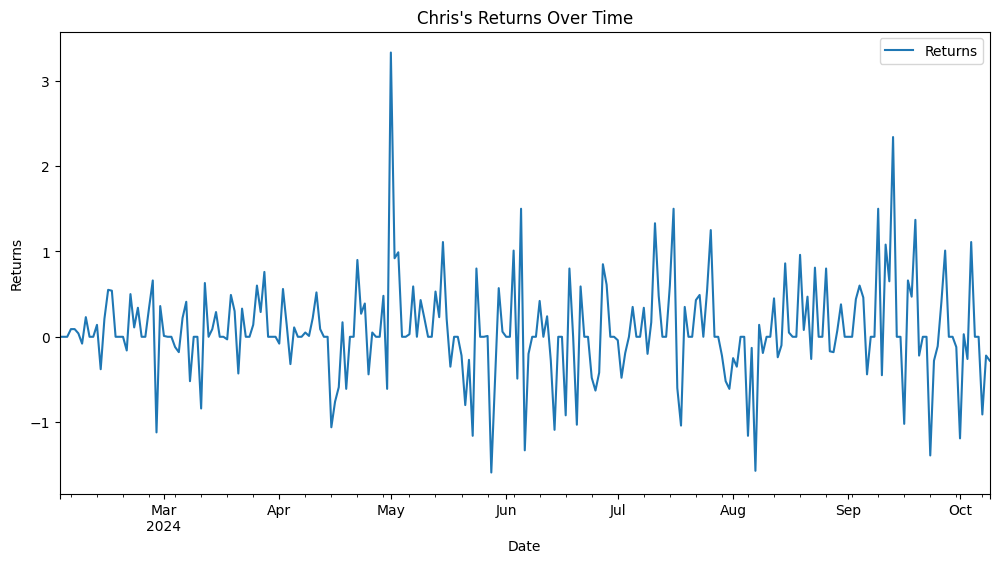

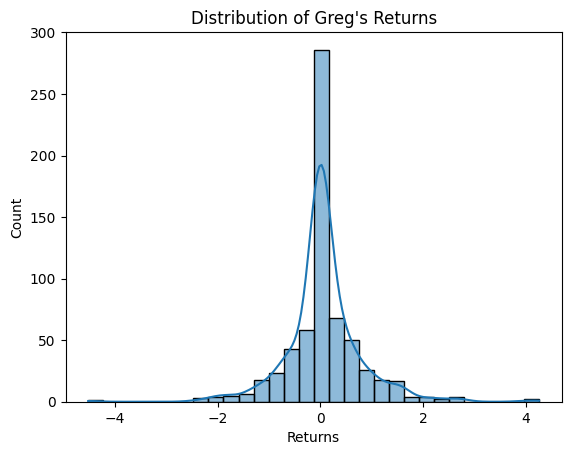

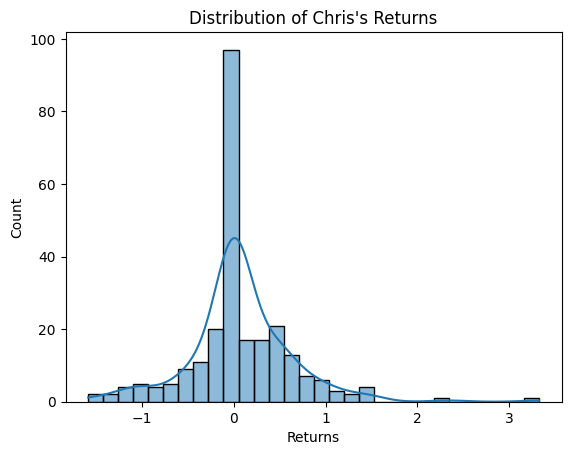

Performing regression analysis on Greg's returns...

 Regression Results for Returns 

                   y     
-------------------------
const          0.0870**  
               (0.0387)  
Mkt-RF         17.4780***
               (4.8721)  
SMB            47.6437***
               (5.6649)  
HML            -13.1155**
               (5.9329)  
R-squared      0.2248    
R-squared Adj. 0.2191    
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01

VIF for Returns:
  feature       VIF
0   const  1.012815
1  Mkt-RF  1.152770
2     SMB  1.353727
3     HML  1.288158

Performing regression analysis on Chris's returns...

 Regression Results for Returns 

                   y     
-------------------------
const          0.0825*   
               (0.0465)  
Mkt-RF         18.9175***
               (6.1351)  
SMB            32.3014***
               (6.2173)  
HML            -12.9610  
               (8.0647)  
R-squared      0.2758    
R-squared Adj. 0.2605    
Standard errors in
pare

In [12]:
# JULY 13 JULY 14 2 REMOVED - IB MISTAKE
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.iolib.summary2 import summary_col

# Function to fetch 10-year Treasury yield using yfinance
def get_risk_free_rate_yfinance():
    treasury_data = yf.download('^TNX', period='1d')
    return treasury_data['Close'].iloc[-1] / 100

# Function to load data from Excel sheets
def load_data(file_path):
    df_greg = pd.read_excel(file_path, sheet_name='Greg')
    df_chris = pd.read_excel(file_path, sheet_name='Chris')
    
    # Convert 'Date' column to datetime and set as index
    for df in [df_greg, df_chris]:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    
    # Remove specific erroneous dates
    for date in ['2023-07-13', '2023-07-14']:
        df_greg = df_greg[~df_greg.index.isin(pd.to_datetime([date]))]
        df_chris = df_chris[~df_chris.index.isin(pd.to_datetime([date]))]
    
    return df_greg, df_chris

# Function to fetch historical data for ETFs
def fetch_etf_data(tickers, start_date='2020-01-01'):
    data = yf.download(tickers, start=start_date)
    returns = data['Adj Close'].pct_change().dropna()
    returns.index = returns.index.tz_localize(None)  # Ensure index is timezone-naive
    return returns

# Function to load Fama-French 5-factor data from CSV
def load_fama_french_factors(file_path):
    fama_french_data = pd.read_csv(file_path)
    fama_french_data['Date'] = pd.to_datetime(fama_french_data['Date'], format='%Y%m%d')
    fama_french_data.set_index('Date', inplace=True)
    
    # Convert percentage returns to decimal
    fama_french_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] /= 100
    
    return fama_french_data

# Function to calculate VIF for multicollinearity check
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

# Function to perform regression analysis
def regression_analysis(returns, fama_french):
    merged_data = returns.join(fama_french).dropna()  # Drop rows with NaN values after merging
    results = {}

    for column in returns.columns:
        y = merged_data[column] - merged_data['RF']
        X = merged_data[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit()
        results[column] = model
        
        # Print a summary table using summary_col for better formatting
        print(f"\n{'=' * 40}")
        print(f" Regression Results for {column} ")
        print(f"{'=' * 40}")
        print(summary_col([model], stars=True, float_format='%0.4f'))
        
        # Calculate VIF for multicollinearity check
        vif = calculate_vif(X)
        print(f"\nVIF for {column}:\n{vif}\n")
    
    return results

# Main execution starts here
risk_free_rate_input = get_risk_free_rate_yfinance()
print(f"Current Risk-Free Rate (10-Year Treasury): {risk_free_rate_input:.4f}\n")

file_path = r"C:\Users\MukeshwaranBaskaran\Downloads\Project_KISKI\Data\chris greg daily returns.xlsx"
df_greg, df_chris = load_data(file_path)

# Fetch ETF data for XBI and SPY
etf_returns = fetch_etf_data(['XBI', 'SPY'])

fama_file_path = r"C:\Users\MukeshwaranBaskaran\Downloads\Project_KISKI\Data\F-F_Research_Data_5_Factors_2x3_daily.CSV"
# Fetch Fama-French factors data
fama_french_factors = load_fama_french_factors(fama_file_path)

# Ensure all indices are timezone-naive before merging
df_greg.index = df_greg.index.tz_localize(None)
df_chris.index = df_chris.index.tz_localize(None)
fama_french_factors.index = fama_french_factors.index.tz_localize(None)

# Merge Greg's and Chris's data with ETF returns and Fama-French factors
merged_greg = df_greg.join(etf_returns).join(fama_french_factors).dropna()
merged_chris = df_chris.join(etf_returns).join(fama_french_factors).dropna()

# Perform correlation analysis
greg_corr = merged_greg.corr()
chris_corr = merged_chris.corr()

print("\nGreg's Correlation Matrix:")
print(greg_corr, "\n")
print("Chris's Correlation Matrix:")
print(chris_corr, "\n")

# Visualize correlation matrices using clustermaps
sns.clustermap(greg_corr, annot=True, cmap='coolwarm', figsize=(10, 8))
plt.title("Greg's Portfolio Correlation Clustermap")
plt.show()

sns.clustermap(chris_corr, annot=True, cmap='coolwarm', figsize=(10, 8))
plt.title("Chris's Portfolio Correlation Clustermap")
plt.show()

# Plot time series of returns
df_greg.plot(title="Greg's Returns Over Time", figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

df_chris.plot(title="Chris's Returns Over Time", figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

# Plot distribution of returns using histograms with KDE overlay
sns.histplot(df_greg['Returns'], kde=True, bins=30)
plt.title("Distribution of Greg's Returns")
plt.show()

sns.histplot(df_chris['Returns'], kde=True, bins=30)
plt.title("Distribution of Chris's Returns")
plt.show()

# Perform regression analysis on Greg's returns
print("Performing regression analysis on Greg's returns...")
greg_regression_results = regression_analysis(df_greg, fama_french_factors)

# Perform regression analysis on Chris's returns
print("Performing regression analysis on Chris's returns...")
chris_regression_results = regression_analysis(df_chris, fama_french_factors)


### Current Risk-Free Rate
- The **risk-free rate** is approximately **4.07%**, serving as a benchmark for assessing the expected returns of other investments, particularly those that carry higher risk.

### Correlation Analysis
- **Greg's Returns:**
  - Greg's returns exhibit a moderate correlation with the overall stock market, as indicated by his link to the SPY ETF, and a stronger correlation with the XBI ETF, which focuses on biotech stocks.
  - His returns are influenced by several market factors:
    - **Market Returns (Mkt-RF):** Greg’s performance benefits significantly from positive market conditions.
    - **Small-Cap Stocks (SMB):** He shows a strong sensitivity to the performance of small-cap companies.
    - **Value Stocks (HML):** His exposure to value stocks is minimal, indicating a preference for growth-oriented investments.
    - **Profitability (RMW):** There is a noticeable negative relationship with high-profit companies, suggesting he may have greater exposure to underperforming stocks.

- **Chris's Returns:**
  - Chris demonstrates a stronger correlation to both SPY and XBI than Greg, indicating a heightened sensitivity to market trends.
  - Similar to Greg, Chris's returns positively correlate with market performance and small-cap stocks but to a greater extent.
  - He also has negligible exposure to value stocks and shares a similar negative relationship with profitability.

### Regression Analysis
- **Greg's Results:**
  - The regression shows that when the market performs well, Greg's returns can increase significantly, especially driven by the performance of small-cap stocks. The coefficients indicate:
    - Constant: **0.0870** (significant at the 5% level)
    - Mkt-RF: **17.4780** (highly significant at the 1% level)
    - SMB: **47.6437** (highly significant at the 1% level)
    - HML: **-13.1155** (significant at the 5% level)
  - The R-squared value of **0.2248** indicates that approximately 22.48% of the variability in Greg’s returns can be explained by the factors in the model.

- **Chris's Results:**
  - Chris’s sensitivity to market conditions is even greater than Greg's. His regression results indicate:
    - Constant: **0.0825** (significant at the 10% level)
    - Mkt-RF: **18.9175** (highly significant at the 1% level)
    - SMB: **32.3014** (highly significant at the 1% level)
    - HML: **-12.9610** (not significant)
  - The R-squared value of **0.2758** suggests that about 27.58% of the variability in Chris’s returns is explained by the model.

### VIF (Variance Inflation Factor)
- Both Greg and Chris exhibit low VIF scores, indicating minimal overlap among the predictors in the regression models. This suggests the results are reliable, with VIF values for Greg and Chris indicating:
  - Greg's VIFs range from **1.0128** to **1.3537**.
  - Chris's VIFs range from **1.0171** to **1.5129**.
  
### Conclusion
- **Overall Comparison:**
  - Both investors are significantly sensitive to market performance and small-cap stocks. However, Chris is generally more reactive to market movements than Greg. Additionally, both have limited exposure to value stocks and demonstrate a negative correlation with highly profitable companies, indicating a potential risk profile that favors growth or speculative investments.
